# Demo of graph optimisation to segment dummy structures

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
from grace.base import GraphAttrs
from grace.models.optimise import optimise_graph
from grace.simulate import random_graph, random_graph_mixed_motifs


### Load a dummy graph:

In [3]:
G = random_graph(n_motifs=5, n_chaff=100, scale=1.0, density=0.025, motif="spiral")

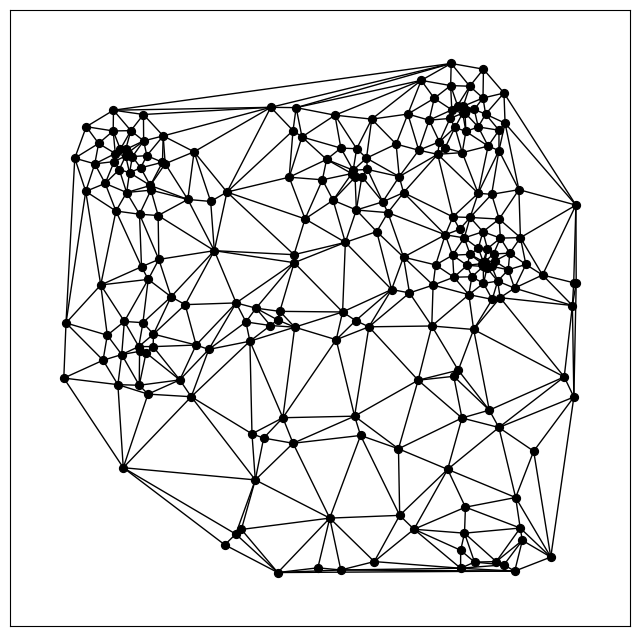

In [4]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in G.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

### Optimise the dummy graph:

In [5]:
# NOTE(arl): this is *super* hacky - just to see if the optimisation works

def update_graph_dummy(G):

    nodes = list(G.nodes.data())

    for _, node in nodes:
        pd = np.random.random()*0.5
        if node["label"] > 0:
            node[GraphAttrs.NODE_PREDICTION] = pd
        else:
            node[GraphAttrs.NODE_PREDICTION] = 1-pd

    
    for edge in G.edges.data():
        pd = np.random.random()*0.1
        _, e_i = nodes[edge[0]]
        _, e_j = nodes[edge[1]]
        
        if e_i["object_idx"] == e_j["object_idx"] and e_i["label"] > 0:
            edge[2][GraphAttrs.EDGE_PREDICTION] = 1 - pd
        else:
            edge[2][GraphAttrs.EDGE_PREDICTION] = pd 


### Update the graph with bimodal node & edge predictions:

In [6]:
update_graph_dummy(G)


##### Visualise how the edge weights are distributed:


In [7]:
def plot_node_and_edge_label_distribution(graph: nx.Graph) -> None: 

    node_true = [node['label'] for _, node in graph.nodes(data=True)]
    node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True)]

    plt.hist(node_true, label=f"GT nodes: {sum(node_true)} / {len(node_true)}")
    plt.hist(node_pred, label=f"Dummy Predictions")
    plt.legend()
    plt.show()



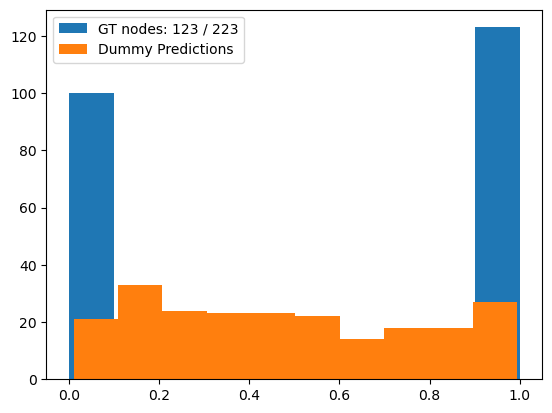

In [8]:
plot_node_and_edge_label_distribution(graph=G)

### Visualise the optimised graph & individual objects:

In [9]:
x = optimise_graph(G)

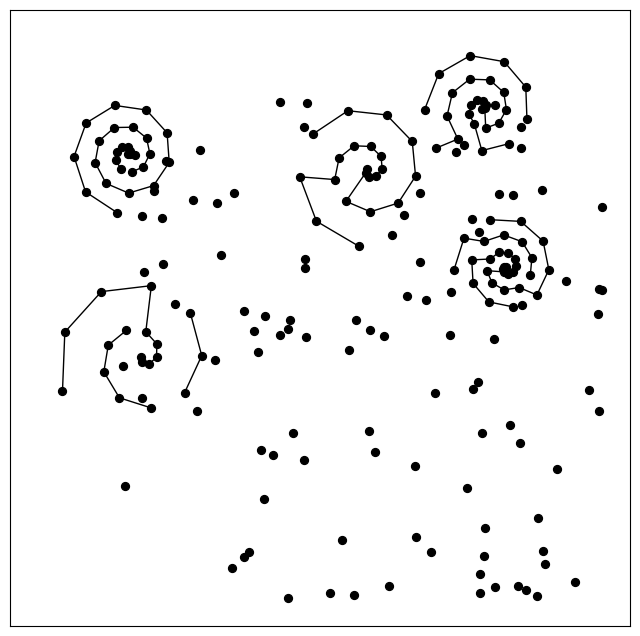

In [10]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)
plt.show()

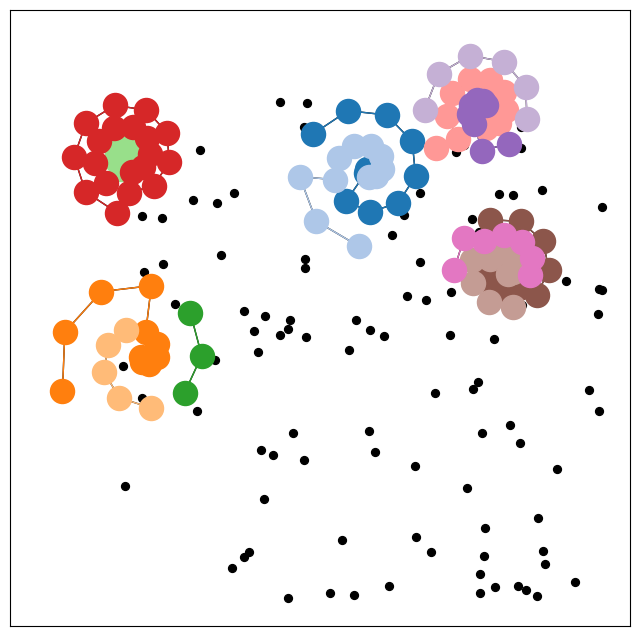

In [11]:

# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

### Repeat on a few graphs at a time:

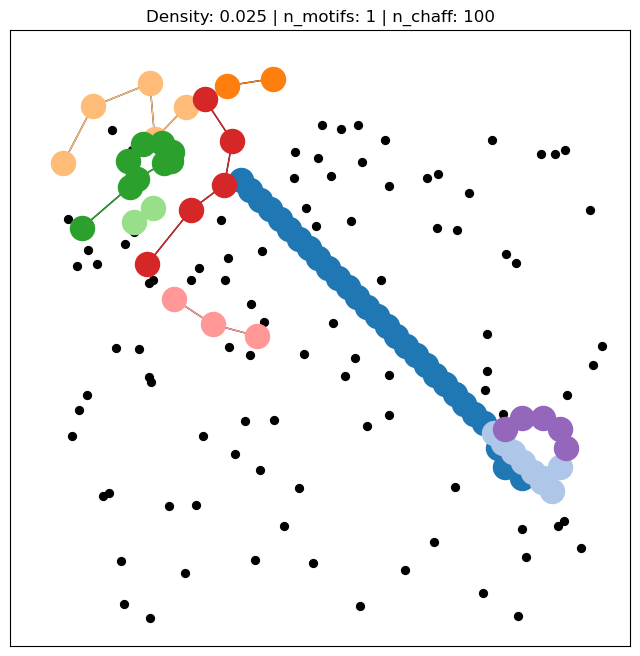

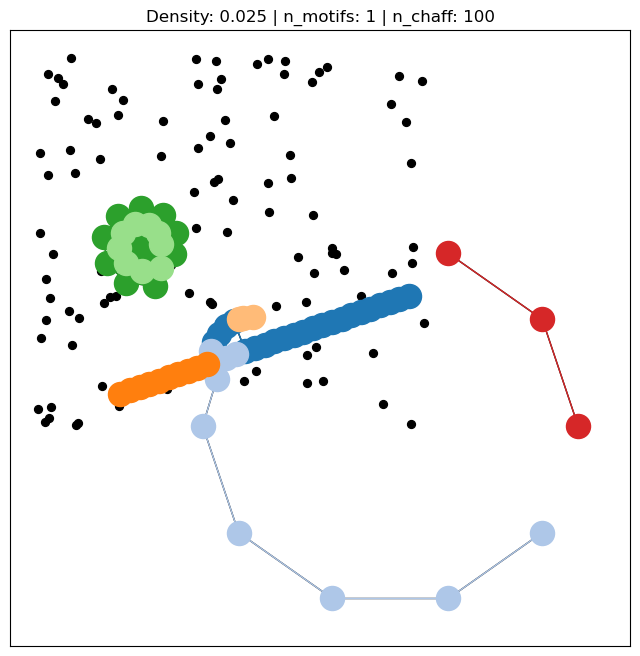

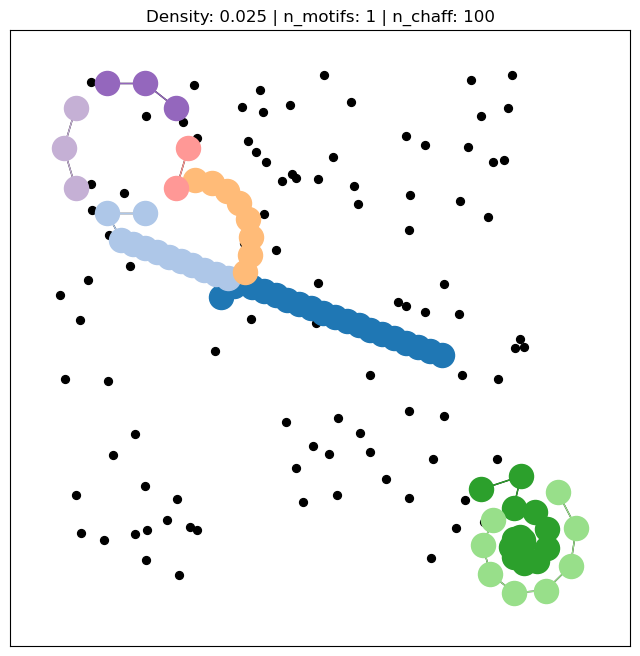

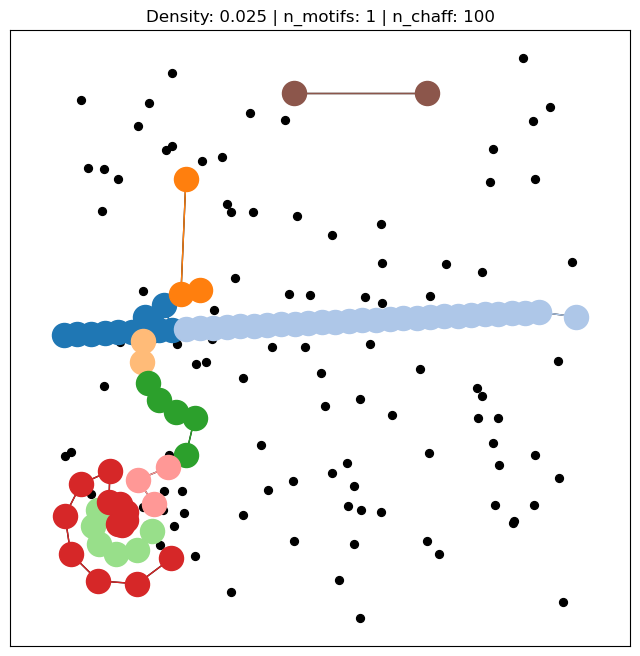

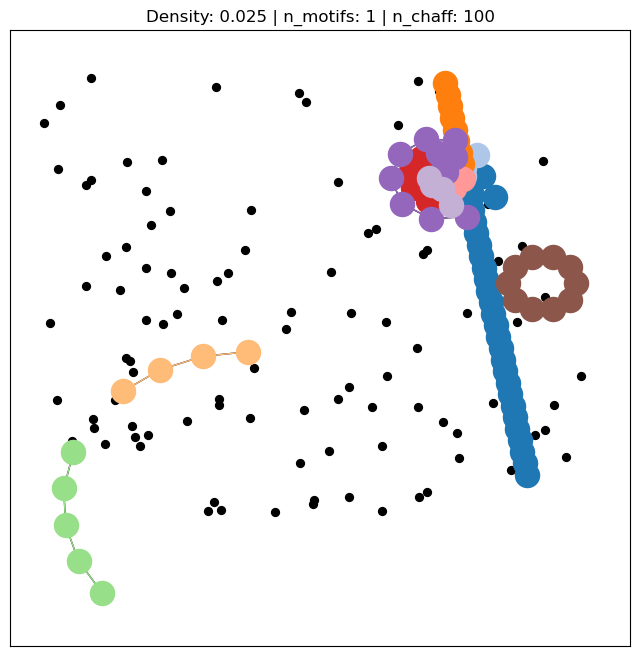

In [12]:
num_trials = 5
density = 0.025
n_motifs = 1
n_chaff = 100

for i in range(num_trials):
    # G = random_graph(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    G = random_graph_mixed_motifs(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    update_graph_dummy(G)
    x = optimise_graph(G)
    
    # Plot:
    pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
    fig, ax = plt.subplots(figsize=(8, 8))

    # draw all nodes/vertices in the graph, including those not determined to be 
    # part of the objects
    nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

    # get each connected subgraph and draw it with a different colour
    cc = nx.connected_components(x)
    for index, sg in enumerate(cc):
        
        if len(sg) <= 1:
            continue

        c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
        sg = x.subgraph(sg).copy()
        plt.title(f"Density: {density} | n_motifs: {n_motifs} | n_chaff: {n_chaff}")
        nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

    plt.show()